In [ ]:
! pip install transformers

     |████████████████████████████████| 3.8 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 62.4 MB/s 
     |████████████████████████████████| 596 kB 54.1 MB/s 
     |████████████████████████████████| 6.5 MB 48.0 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount("/content/DATA")

Mounted at /content/DATA


In [ ]:
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchtext.legacy.data import Field, LabelField, BucketIterator, TabularDataset

import spacy
import numpy as np
import pandas as pd

import random
import math
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Yelp Dataset

In [ ]:
# with open("/content/1000.pos",'r') as f:
#   p_data = f.read().split('\n')
#   # print(data)

# with open("/content/1000.neg",'r') as f:
#   n_data = f.read().split('\n')

Amazon dataset

In [ ]:
p_data = pd.read_csv("/content/amazon_pos_data.csv")['review'].tolist()
n_data = pd.read_csv("/content/amazon_neg_data.csv")['review'].tolist()

In [ ]:
# with open("/content/tsmh_pos.txt",'r') as f:
#   p_test_data = f.read().split('\n')[:-1]
#   # print(data)

# with open("/content/tsmh_neg.txt",'r') as f:
#   n_test_data = f.read().split('\n')[:-1]


# for i,review in enumerate(p_test_data):
#   p_test_data[i] = review[1:-3].strip()


# for i,review in enumerate(n_test_data):
#   n_test_data[i] = review[1:-3].strip()

In [ ]:
p_data[-1]

'evening clutch bag'

In [ ]:
Positive_train = list(set(p_data[:10000]))
# Positive_val = list(set(Positive[-1000:]['review']))
Positive_test = list(set(p_data[14000:]))

Negative_train = list(set(n_data[:10000]))
# Negative_val = list(set(Negative[-1000:]['review']))
Negative_test = list(set(n_data[14000:]))
len(Positive_train) ,len(Negative_train) , len(Positive_test), len(Negative_test)

(9073, 8942, 968, 959)

In [ ]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer(text):
  return text.split()
  # return [tok.text for tok in spacy_en.tokenizer(text)]


def add_tokens(x):
  x = [tok.text for tok in spacy_en.tokenizer(x)]
  while len(x) < 5:
    x = x + ['<pad>']

  return " ".join(x)

In [ ]:
Train = pd.DataFrame({"review": Positive_train + Negative_train, "label": [1]*len(Positive_train) + [0]*len(Negative_train)})
# Val = pd.DataFrame({"review": Positive_val + Negative_val, "label": [1]*len(Positive_val) + [0]*len(Negative_val)})
Train = Train.sample(frac = 1)
Test = pd.DataFrame({"review": Positive_test + Negative_test, "label": [1]*len(Positive_test) + [0]*len(Negative_test)})
# Test = Test.sample(frac = 1)

Train['review'] = Train['review'].apply(add_tokens)
# Val['review'] = Val['review'].apply(add_tokens)
Test['review'] = Test['review'].apply(add_tokens)

Train.to_csv('/content/train.csv',index=False)
# Val.to_csv('/content/val.csv',index=False)
Test.to_csv('/content/test.csv',index=False)
Test.tail(5)

,review,label
1922,"ripoff , like the rest of the stones remastered",0
1923,not as good as high fidelity,0
1924,boring ! boring ! boring !,0
1925,should have listened to the other reviews ...,0
1926,disappointing ! ! <pad> <pad>,0


In [ ]:
REVIEW = Field(sequential=True,
               tokenize = tokenizer,
               use_vocab = True, 
               # init_token = '<sos>', 
               # eos_token = '<eos>', 
               lower = True,
               batch_first = True)

LABEL = LabelField(dtype=torch.long, 
                   batch_first=True, 
                   sequential=False)

fields = [('review', REVIEW), ('label',LABEL)] # ('token_type', TTYPE), ('start',START), ('end',END)]

In [ ]:
train_data, val_data, test_data = TabularDataset.splits(
                                        path = '/content/',
                                        train = 'train.csv',
                                        validation = 'test.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)
print(type(train_data))

<class 'torchtext.legacy.data.dataset.TabularDataset'>


In [ ]:
REVIEW.build_vocab(train_data,val_data, min_freq = 1) # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'>
LABEL.build_vocab(train_data, test_data)
print(len(REVIEW.vocab),len(LABEL.vocab))
print(REVIEW.vocab.stoi['<eos>'] , REVIEW.vocab.stoi['<sos>'], REVIEW.vocab.stoi['<pad>'])
print(train_data[0].__dict__.keys())
print(train_data[20].__dict__.values())
print(list(REVIEW.vocab.stoi.items())[:10])


BATCH_SIZE = 10

train_iterator, val_iterator, test_iterator = BucketIterator.splits(
                                                      (train_data, val_data, test_data), 
                                                      batch_size = BATCH_SIZE,
                                                      sort_key = lambda x : len(x.review),
                                                      shuffle = False,
                                                      device = device
                                                    )

12745 2
0 0 1
dict_keys(['review', 'label'])
dict_values([['fun', 'film', '<pad>', '<pad>', '<pad>'], '1'])
[('<unk>', 0), ('<pad>', 1), ('!', 2), ('the', 3), ('a', 4), (',', 5), ('.', 6), ('of', 7), ('not', 8), ('this', 9)]


In [ ]:
for batch in test_iterator:
  print(batch.review)
  break

tensor([[ 5776,  1814,    10,  1175,    20],
        [ 1593,  1137,    35,  2203,   944],
        [ 1424,   238,  1158,  6968,     6],
        [ 5783,   120,   630,     1,     1],
        [   18,     7,  2697,  2032,     1],
        [ 1376,     3,   262,     1,     1],
        [ 2897,  1998, 12077,     1,     1],
        [  142,   289,     1,     1,     1],
        [  189,    19,     1,     1,     1],
        [  170,     1,     1,     1,     1]])


In [ ]:
from torch import nn
import torch.nn.functional as F

class TextClassificationModel(nn.Module):

  def __init__(self, vocab_size, embed_dim, num_filters, num_class):
    super(TextClassificationModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=False)
    self.fc = nn.Linear(num_filters, num_class)
    self.dropout = nn.Dropout(0.25)
    self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size = (2,embed_dim), stride = 1, padding = 0, padding_mode='zeros', dilation=1, bias = True)
    self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size = (3,embed_dim), stride = 1, padding = 0, padding_mode='zeros', dilation=1, bias = True)
    self.conv4 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size = (4,embed_dim), stride=1, padding = 0, padding_mode= 'zeros', dilation=1, bias = True)
    self.conv5 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size = (5,embed_dim), stride=1, padding = 0, padding_mode = 'zeros', dilation=1, bias = True)

    self.init_weights()


  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.conv3.weight.data.uniform_(-initrange, initrange)
    self.conv4.weight.data.uniform_(-initrange, initrange)
    self.conv5.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, X):

    # X, Y = [batch size, seq len] , [batch size]

    embedded = self.dropout(self.embedding(X))

    # embedded = [batch size, seq len, emb dim]

    embedded = embedded.unsqueeze(1)

    # embedded = [batch size, channel , seq len, emb dim]
    e2 = self.conv2(embedded)
    e3 = self.conv3(embedded) # [ batch size, channel , seq len - 3 + 1, 1]
    e4 = self.conv4(embedded) # [ batch size, channel , seq len - 4 + 1, 1]
    e5 = self.conv5(embedded) # [ batch size, channel , seq len - 5 + 1, 1]

    e2 = F.max_pool2d(e2, kernel_size=(e2.shape[-2],1)).squeeze(1).squeeze(-1)  # [batch size, 1]
    e3 = F.max_pool2d(e3, kernel_size=(e3.shape[-2],1)).squeeze(1).squeeze(-1)  # [batch size, 1]
    e4 = F.max_pool2d(e4, kernel_size=(e4.shape[-2],1)).squeeze(1).squeeze(-1)   # [batch size , 1 ]
    e5 = F.max_pool2d(e5, kernel_size=(e5.shape[-2],1)).squeeze(1).squeeze(-1)    # [batch size , 1 ]

    return self.fc(torch.concat((e2,e3,e4,e5),dim=-1))

sentiment_model = TextClassificationModel(len(REVIEW.vocab), 300, 4, 2).to(device)
# sentiment_model.embedding.weight.data.copy_(REVIEW.vocab.vectors)
sentiment_model.embedding.weight.requires_grad = True
# model.embedding.weight

optimizer = optim.Adam(sentiment_model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
sentiment_model.load_state_dict(torch.load("/content/DATA/MyDrive/LAB_work/TSMH/amazon_classification_yoon_kim_model.pt",map_location=device))

<All keys matched successfully>

In [ ]:
test_acc = 0
sentiment_model.eval()
with torch.no_grad():

  for batch in test_iterator:

      X = batch.review.to(device)
      # print(X.size())
      Y = batch.label.to(device)

      y_pred = sentiment_model(X)
      
      # for i,x in enumerate(X):
        # for tokens in x.numpy().tolist():
        #   print(REVIEW.vocab.itos[tokens],end=' ')
        # print()
        # print(y_pred[i])
        
      test_acc += (y_pred.argmax(dim=-1) == Y).sum().item()

print(f"Test Acc : {test_acc/(2000):.4f}")

Test Acc : 0.7625


TSMH algorithm for generating text

In [ ]:
U = dict()
# U["[QWH]"] = ["what", "when", "where", "which", "who", "whom", "whose", "why", "how"]
# AUX = []
# U["[NEG]"] = ['not','none','never','no','no one',"negative", 'neither','bad', 'horrible','unworthy','nuisance', 'horrifying experience','stupid choice', 'illegal activities','illogical' ,'horrendous', "unexpected" ,"is not","would not","false","nuisance","nasty",'depressing','disgusting','do not','against','disapprove','disgrace','aweful','unpleasant','troublesome','abhor','abominable','angry','annoy', 'annoying experience', 'beware', 'boring','brutal','misfortune','catastrophic decision','waste of resources'] # ,'disappointment','disappointing','disappoint','destructive','destruction','meangingless','gruesome']
U["[POS]"] = ['nice','wow','amazing','approve','yes',"positive", 'either','amused', 'smooth','totally worthy of','good', 'even better','not at all stupid choice', 'perfect',"clean","superb",'recommend','graceful attitude','pleasant','peaceful',"awesome","how nice","superb",'graceful','jubiliant','exquisite','dazzling','bliss','favourable','marvellous','lucid','intellectual choice','novel','robust','thriving','virtuous','amicable','appreciate','brilliant','cajole','bravo','really brave','captivating','charming','colourful','coolest item ever !','commendable'] # ,'disappointment','disappointing','disappoint','destructive','destruction','meangingless','gruesome']

U["[NN]"] = []
# U["[NNP]"] = []

with open("/content/DATA/MyDrive/LAB_work/TSMH/verbs.txt",'r') as f:
  temp = f.read().split('\n')
  U["[AUX]"] = [x for x in temp if x not in "[POS]"]

# print(len(AUX))  # 4576
vocab_partition = ["[AUX]", "[POS]", "[OTH]"]
U.keys()

dict_keys(['[POS]', '[NN]', '[AUX]'])

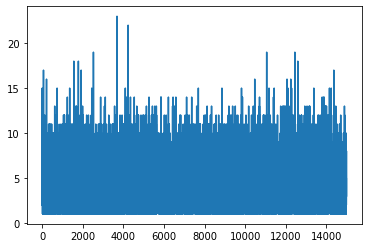

In [ ]:
Data = []

# with open('/content/1000.pos','r') as f:
#   temp = f.read().split('\n')
#   Data = [x for x in temp]

# print(len(Data)) # 1001

Data = pd.read_csv("/content/amazon_pos_data.csv")['review'].tolist()
# Data = [x for x in temp]


import matplotlib.pyplot as plt

plt.plot([len(x.split()) for x in Data])
plt.show()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

ex = "disappointing experience from the cake factory!!"
def Name_entity_recognition(sent):
    sent = word_tokenize(sent)
    sent = pos_tag(sent)
    return sent

for d in Data:
  sent = Name_entity_recognition(d)
  for s in sent:
    if s[-1] == "NNS" or s[-1] == "NN":
      U['[NN]'].append(s[0])

for ele in set(U['[AUX]']).intersection(set(U['[NN]'])):
  U['[AUX]'].remove(ele)


for ele in set(U['[AUX]']).intersection(set(U['[POS]'])):
  U['[AUX]'].remove(ele)


U['[AUX]'] = list(set(U['[AUX]']))
# U['[POS]'] = list(set(U['[POS]']))
U['[NN]'] = list(set(U['[NN]']))
U['[POS]'] = list(set(U['[POS]']))
# U['[QWH]'] = list(set(U['[QWH]']))
# U['[AUX]'] = set(U['[AUX]'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
U.keys()

dict_keys(['[POS]', '[NN]', '[AUX]'])

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import BertTokenizer, BertForMaskedLM

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForMaskedLM.from_pretrained("bert-base-uncased")

gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def BERT_Sentence_generator(sent):

  # tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  # bert_model = BertForMaskedLM.from_pretrained("bert-base-uncased")
  bert_output = []

  # sample 1 sentence from one the of constraint satisfaction class
  # sent = random.sample(list(temporary_set),1)

  bert_model.eval()
  inputs = bert_tokenizer.encode(sent[0], return_tensors="pt")
  labels = bert_tokenizer.encode(sent[0], return_tensors="pt")

  outputs = bert_model(inputs, labels=labels)
  loss = outputs.loss
  logits = outputs.logits
  bert_output.append(bert_tokenizer.decode(logits.argmax(dim=-1)[0].detach().cpu().numpy()))

  return bert_output

# ********************************************#


def GPT2_Scorer(sentence):

  # tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
  # gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

  inputs = gpt2_tokenizer(sentence, return_tensors="pt")  # sentence = "Hello, my dog is cute"
  outputs = gpt2_model(**inputs, labels=inputs["input_ids"])
  loss = outputs.loss
  # logits = outputs.logits

  return np.exp(-loss.detach().cpu()*inputs["input_ids"].shape[-1])


# ********************************************#


def Sentiment_Scorer(bert_output):
  sentiment_model.eval()

  bert_output = add_tokens(bert_output)

  # assert len(bert_output.split()) >= 5, "Sentiment analysis model would fail !!"
 
  with torch.no_grad():
    X = torch.tensor([REVIEW.vocab.stoi[token] for token in bert_output.split()]).unsqueeze(0).to(device)
    try:
      Y = sentiment_model(X).squeeze(0)
    except :
      return 0

    Y = Y.detach().cpu()
    sentiment_score = F.log_softmax(Y).numpy()[0]
  
  return np.exp(sentiment_score)


In [ ]:
import random
import copy

constraint_count_set = dict()
operations = ["insert", "replace", "delete", "none"]
vocab_partition = ["[AUX]","[POS]","[NN]","[OTH]"]

#***************************************#
def Count_constraints(sentence):

  global vocab_partition

  temp = dict()

  for i in vocab_partition:
    temp[i] = 0

  cnt = 0

  # print(f"Inside Count_constraint function: {sentence}, {len(vocab_partition)}")

  for word in sentence.split():
    for _ in vocab_partition:
      temp[_]  += int((_ in U.keys() and word in U[_]) or (_ == word))

  for _ in vocab_partition:
    cnt += int((_ == '[POS]' and temp[_]>= 1) or  (_ != '[POS]' and temp[_]>0))

  return len(vocab_partition) - cnt


# **************************************#

def dfs(sampled_indices,ner_list,sent,idx=0):

  # print(sampled_indices)
  if len(sampled_indices) == 0:
    # print("Got into 0")
    constraint_count_set[Count_constraints(sent)].append(sent)
    return 
  
  if idx == sampled_indices[0]:
    # print("Got into")
    sampled_indices = sampled_indices[1:]
    
    for operation in operations:
      sentence = copy.deepcopy(sent)
      if operation == 'none':
        sentence += ' ' + ner_list[idx][0] # ("string", "NER tag")
        dfs(sampled_indices,ner_list,sentence,idx+1)
      if operation == 'delete':
        dfs(sampled_indices,ner_list,sentence,idx+1)
      if operation == 'insert' or operation == 'replace':
        for vocab in vocab_partition:
          # if vocab != '[OTH]':
          sentence += ' ' + vocab
          dfs(sampled_indices,ner_list,sentence,idx+1)
      # if operation == 'replace':
        # for vocab in vocab_partition:
        #   if vocab in U.keys():
        #     sentence += ' ' + vocab
        #     dfs(sampled_indices,ner_list,sentence,idx+1)
  else:
    sent += ' ' + ner_list[idx][0]
    dfs(sampled_indices,ner_list,sent,idx+1)



# **************************************#




In [ ]:
import queue
import threading
from threading import Thread

In [ ]:
new_pos_sent = []

In [ ]:
for data in Data[250:]:
  chosen_sentence = data
  print(f"Input Sentence: {chosen_sentence}")

  constraint_count_set = dict()
  operations = ["insert", "replace", "delete", "none"]
  vocab_partition = ["[AUX]","[POS]","[NN]","[OTH]"]

  k = 4   # number of positions to sample from the input sentence


  # 5 MCMC steps
  for iter in range(5):

    # print(f"#*********************# Step : {iter+1} #*********************#")

    # randomly choose k positions
    ner_list = Name_entity_recognition(chosen_sentence)
    # print(ner_list)

    # vocab_partition.append()
    # print(vocab_partition)

    #sample indices to carry out combination of operations
    sampled_indices = sorted(random.sample(list(range(len(ner_list))),min(k,len(ner_list))))

    # initialise the a map: int --> list, # num constraints satisfied --> the list of sentences doing so
    for i in range(10):
      constraint_count_set[i] = []

    # ner_list_copy = copy.deepcopy(ner_list)

    dfs(sampled_indices,ner_list,"",0)

    # for k,v in constraint_count_set.items():
    #   print(len(v))

    temporary_set = set()
    for _,v in constraint_count_set.items():
      if len(v) > 0:
        for sentence in v:
          temp = sentence.split()
          for idx,token in enumerate(temp):
            if token == '[POS]':  # replace the Negative tokens by sampling from the [POS] subset
              temp[idx] = random.sample(U["[POS]"],1)[0]
            elif token == '[NN]':   # replace the Noun tokens by sampling from the [NN] subset
              temp[idx] = random.sample(U["[NN]"],1)[0]
            elif token[0] == '[':  # rest of the tokens to be replaced by words generated from BERT
              temp[idx] = '[MASK]'
              
          temporary_set.add(' '.join(temp))
        break  # acting only on the set of max constraint satisfaction

    # print(temporary_set)
    # print(f"{len(temporary_set)} sentences generated !")

    que = queue.Queue()

    threads_list = list()
    
    sentence = random.sample(list(temporary_set),1)
    bert_output = BERT_Sentence_generator(sentence)
    # PI = GPT2_Scorer(bert_output[0][1:-1])
    # sentiment_score = Sentiment_Scorer(bert_output[0][1:-1])

    t1 = threading.Thread(target=lambda q, arg1: q.put(GPT2_Scorer(arg1)), args=(que, bert_output[0][1:-1]))
    t2 = threading.Thread(target=lambda q, arg1: q.put(Sentiment_Scorer(arg1)), args=(que, bert_output[0][1:-1]))  
    # starting threads
    t1.start()
    t2.start()
    threads_list.append(t1)
    threads_list.append(t2)


    t3 = threading.Thread(target=lambda q, arg1: q.put(GPT2_Scorer(arg1)), args=(que, chosen_sentence))
    t4 = threading.Thread(target= lambda q, args1: q.put(Sentiment_Scorer(args1)), args=(que, chosen_sentence))

    # starting threads
    t3.start()
    t4.start()


    threads_list.append(t3)
    threads_list.append(t4)

    # Join all the threads
    for t in threads_list:
        t.join()

    # Check thread's return value
    result = []
    while not que.empty():
      result.append(que.get())

    '''result = []
    result.append(GPT2_Scorer(bert_output[0][1:-1]))
    result.append(Sentiment_Scorer(bert_output[0][1:-1]))

    result.append(GPT2_Scorer(chosen_sentence))
    result.append(Sentiment_Scorer(chosen_sentence))'''

    assert len(result) == 4, f"Only {len(result)} threads have merged out of {4} !!"

    Acceptance_rate = min(1,(result[0]*result[1])/(result[2]*result[3]))

    if Acceptance_rate == 1:
      chosen_sentence = bert_output[0][1:-1]

  print(f"Output sentence : {chosen_sentence[1:-1]}")
  new_pos_sent.append(chosen_sentence[1:-1])
  print('*' * 50)


In [ ]:
print(len(new_pos_sent))

58


In [ ]:
for _ in new_pos_sent:
  print('"',_,'"',',')

" he's a really brave and peaceful end.. luc i appreciate building and capting my dads'friend, and how a pleasant. hes, of course like floor " ,
" an extremely peaceful bracelet, that i would recommend money instead of, yes glassware not at all stupid and brilliant, a positive zone that amused giordano to bequentle " ,
" and an arm of even better contech technology, a very more luc " ,
" the jubilientt and dazzling carpenters were the marvel of a captivating fav " ,
" oh, good to graceful and wow guerou. good to the awesomeness. a little com. good to " ,
" best novel ( ), ae125 ( michael crlanton ) exquisitely pleasant microwave ( favourable service, cool best item ever ) best attitude ) : h'allo! grandmas ( oh how nice ) nice database " ,
" how much more bertful mathematics in hick and and is not at all stupid so much positive infrequentness ` ` dijoy a really brave placebo " ,
" not totally worthy of wayne ander, but even better annabel. even more superb and not at all stupid choice 

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
pos_, neg_ = 0, 0
for review in new_pos_sent:
  # Write a review as one continuous string (multiple sentences are ok)
  # review = "many unworthy repairs, terrible repairs, bad quesadilla"
  # Obtain the sid scores for your review
  score = sid.polarity_scores(review) # dictionary
  neg_ += score['neg']
  pos_ += score['pos']
print(pos_,neg_)

1.439 6.296999999999999


In [ ]:
sid.polarity_scores("don't waste your money !!!")

{'compound': 0.4953, 'neg': 0.0, 'neu': 0.555, 'pos': 0.445}